In [ ]:
from transformers import TimesformerConfig, TimesformerModel

# Initializing a TimeSformer timesformer-base style configuration
configuration = TimesformerConfig()

# Initializing a model from the configuration
model = TimesformerModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
# Ensure that transformers is installed
# pip install transformers

import torch
from transformers import TimesformerForVideoClassification

# Load the pre-trained Timesformer model
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the model architecture (optional)
print(model)


TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

In [ ]:
import os

def load_dataset(directory):
    data = []
    for category in os.listdir(directory):
        class_path = os.path.join(directory, category)
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            data.append((video_path, category))  # Make sure this tuple is being created
            print(f"Added ({video_path}, {category})")  # Debug print
    return data
train_data = load_dataset('C:/Users/T2420318/Dataset/output_dataset (1)/train')
test_data = load_dataset('C:/Users/T2420318/Dataset/output_dataset (1)/test')

# Print some sample data to verify
print("Sample training data:", train_data[:5])
print("Sample testing data:", test_data[:5])
print("training Data shape",train_data.shape())
print("Training Data length:", len(train_data))
print("Testing Data length:", len(test_data))



Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse001_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse003_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse004_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse005_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse006_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse007_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse008_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse010_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse011_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse013_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse015_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/tr

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# for batch_idx, batch in enumerate(train_loader):
#     print(f"Batch {batch_idx} content: {batch}")
#     print(f"Batch {batch_idx} length: {len(batch)}")


In [ ]:
# for batch in train_loader:
#     print("Batch type:", type(batch))
#     print("Batch contents:", batch)
#     print("Data shape:", batch[0].shape)
#     print("Target shape:", batch[1].shape)
#     break

In [ ]:
import torch
import gc
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torchvision.io import read_image
from torchvision.transforms import Resize, Compose, Normalize, ToPILImage, ToTensor
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from torch.cuda.amp import autocast, GradScaler
class VideoDataset(Dataset):
    def __init__(self, data, class_to_idx, num_frames=16, transform=None):
        self.data = data
        self.class_to_idx = class_to_idx
        self.num_frames = num_frames
        self.transform = transform
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}  # Map indices to class names

    def __getitem__(self, idx):
        video_path, category = self.data[idx]
        label = self.class_to_idx[category]

        frames = []
        frame_files = sorted([f for f in os.listdir(video_path) if f.endswith('.jpg')])
        frame_indices = torch.linspace(0, len(frame_files) - 1, self.num_frames).long()
        for i in frame_indices:
            frame_path = os.path.join(video_path, frame_files[i])
            frame = read_image(frame_path).float() / 255.0
            frame = frame if frame.shape[0] == 3 else frame.expand(3, -1, -1)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)

        frames = torch.stack(frames)  # Shape: [num_frames, channels, height, width]
        frames = frames.permute(1, 0, 2, 3)  # Shape: [num_frames, height, width, channels]

        return frames, label

    def __len__(self):
        return len(self.data)



def load_dataset(directory):
    data = []
    for category in os.listdir(directory):
        class_path = os.path.join(directory, category)
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            data.append((video_path, category))
    return data

# Transformation pipeline for frames
transform = Compose([
    Resize((224, 224)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_to_idx = {'Abuse': 0, 'Arrest': 1, 'Assault': 2, 'Fighting': 3,
                'Explosion': 4, 'Burglary': 5, 'Arson': 6, 'Normal': 7}

# Load dataset paths
train_data = load_dataset('C:/Users/T2420318/Dataset/output_dataset (1)/train')
test_data = load_dataset('C:/Users/T2420318/Dataset/output_dataset (1)/test')

# Create dataset objects
train_dataset = VideoDataset(train_data, class_to_idx, transform=transform)
test_dataset = VideoDataset(test_data, class_to_idx, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
# Print the dataset size
import torch

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Test the first item in the train dataset
first_train_sample = train_dataset[0]  # Access the first sample
frames, label = first_train_sample

print("\nFirst training sample:")
print(f" - Frames shape: {frames.shape}")  # Should be [num_frames, height, width, channels]
print(f" - Label: {label} ({train_dataset.idx_to_class[label]})")  # Print label and its corresponding class

# Check the DataLoader
for i, (data, targets) in enumerate(train_loader):
    print("\nBatch from DataLoader:")
    print(f" - Batch frames shape: {data.shape}")  # [batch_size, num_frames, height, width, channels]
    print(f" - Batch targets: {targets}")
    break  # Print only the first batch



Number of training samples: 149
Number of testing samples: 54

First training sample:
 - Frames shape: torch.Size([3, 16, 224, 224])
 - Label: 0 (Abuse)

Batch from DataLoader:
 - Batch frames shape: torch.Size([4, 3, 16, 224, 224])
 - Batch targets: tensor([6, 7, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.619886].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1119993..2.640001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9205741..0.9459063].


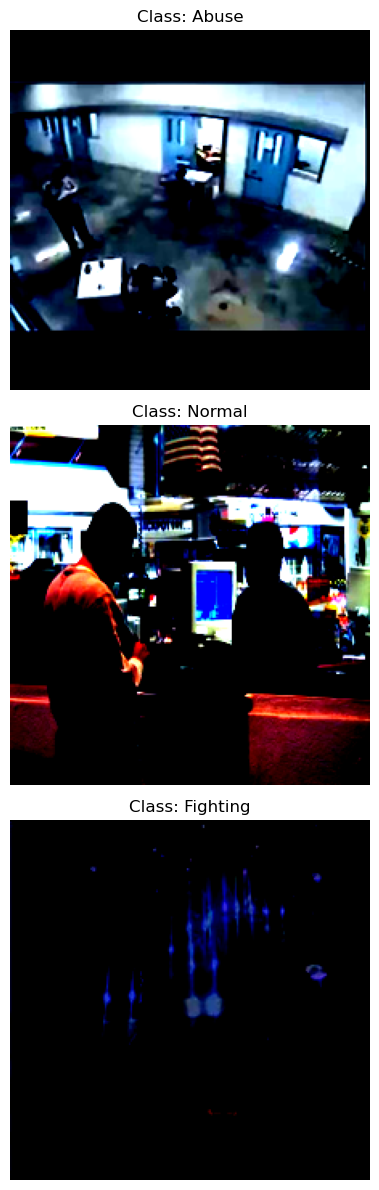

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to visualize random samples
def visualize_random_frames(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 1, figsize=(6, num_samples * 4))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        frames, label = dataset[idx]  # Get frames and label
        label_name = dataset.idx_to_class[label]

        # Convert first frame from CHW to HWC format for Matplotlib
        first_frame = frames[:, 0, :, :].permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, C]

        # Plot the first frame of the video
        axes[i].imshow(first_frame)
        axes[i].set_title(f"Class: {label_name}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Call function to visualize train dataset
visualize_random_frames(train_dataset, num_samples=3)


In [ ]:
# import faulthandler
# faulthandler.enable()
# import torch
# from tqdm import tqdm
# from torch.amp import autocast, GradScaler
# from torch.optim.lr_scheduler import StepLR
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# import torchvision.transforms as transforms
# from transformers import TimesformerForVideoClassification

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load Timesformer model and adjust output layer
# model = TimesformerForVideoClassification.from_pretrained(
#     "facebook/timesformer-base-finetuned-k400"
# )
# model.classifier = torch.nn.Linear(model.classifier.in_features, 8)  # Replace the output layer
# model = model.to(device)

# # Training function
# def train_timesformer(model, train_loader,test_loader, device, epochs=25):
#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []

#     # Optimizer, Gradient Scaler, and Scheduler
#     optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
#     scaler = GradScaler()
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

#     # Compute class weights
#     labels = [label for _, label in train_loader.dataset]
#     classes = np.unique(labels)  # Ensure it's a NumPy array
#     class_weights = compute_class_weight(
#         class_weight="balanced", classes=classes, y=labels
#     )
#     class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#     loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

#     model.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}')

#         for batch_idx, (data, target) in progress_bar:
#             data, target = data.to(device), target.to(device)

#             if data.ndim == 6:  # Check for unnecessary dimensions
#                 data = data.squeeze(1)

#             # Timesformer expects shape [batch, num_frames, channels, height, width]
#             data = data.permute(0, 2, 1, 3, 4)  # Rearrange dimensions

#             optimizer.zero_grad()

#             # Mixed precision training
#             with autocast(device_type="cuda"):
#                 outputs = model(pixel_values=data)
#                 loss = loss_fn(outputs.logits, target)

#             # Gradient scaling for mixed precision
#             scaler.scale(loss).backward()

#             # Gradient Clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#             scaler.step(optimizer)
#             scaler.update()

#             running_loss += loss.item()
#             _, predicted = outputs.logits.max(1)
#             correct += predicted.eq(target).sum().item()
#             total += target.size(0)

#             progress_bar.set_postfix({
#                 'Loss': f'{running_loss / (batch_idx + 1):.4f}',
#                 'Accuracy': f'{100 * correct / total:.2f}%'
#             })

#         train_losses.append(running_loss / len(train_loader))
#         train_accuracies.append(100 * correct / total)
#         scheduler.step()  # Update learning rate
#         test_loss, test_accuracy, _, _ = evaluate_with_predictions(model, test_loader, device)
#         test_losses.append(test_loss)
#         test_accuracies.append(test_accuracy)

#         # Summary at the end of each epoch
#         # print(f"End of Epoch {epoch + 1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%")
#         print(f"End of Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

#     return train_losses, train_accuracies, test_losses, test_accuracies

# # Example usage
# # Assume 'train_loader' is defined with data augmentation transforms

# # Define data augmentations
# data_augmentations = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Clear GPU memory
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

# # Train the model
# train_losses, train_accuracies, test_losses, test_accuracies = train_timesformer(model, train_loader, test_loader, device="cuda", epochs=25)


In [ ]:
import faulthandler
faulthandler.enable()
import torch
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torchvision.transforms as transforms
from transformers import TimesformerForVideoClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Timesformer model and adjust output layer
model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400"
)

model.classifier = torch.nn.Linear(model.classifier.in_features, 8)  # Replace the output layer
model = model.to(device)


# ✅ Fixed Training Function
def train_timesformer(model, train_loader, test_loader, device, epochs=25):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_test_acc = 0
    patience = 5

    # Optimizer, Gradient Scaler, and Scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
    scaler = GradScaler()
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    # ✅ Compute Class Weights (Fix NumPy Issue)
# ✅ Compute Class Weights (Fixed for 6 classes)

    labels = np.array([label for _, label in train_loader.dataset])
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(labels), y=labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}')

        for batch_idx, (data, target) in progress_bar:
            data, target = data.to(device), target.to(device)

            if data.ndim == 6:  # Check for unnecessary dimensions
                data = data.squeeze(1)

            # ✅ Correct Tensor Shape for TimeSformer
            data = data.permute(0, 2, 1, 3, 4)  # [batch, num_frames, channels, height, width]

            optimizer.zero_grad()

            # Mixed precision training
            with autocast(device_type="cuda"):
                outputs = model(pixel_values=data)  # ✅ FIXED: Correct input format
                loss = loss_fn(outputs.logits, target)

            # ✅ Gradient scaling for mixed precision
            scaler.scale(loss).backward()

            # ✅ Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

            progress_bar.set_postfix({
                'Loss': f'{running_loss / (batch_idx + 1):.4f}',
                'Accuracy': f'{100 * correct / total:.2f}%'
            })

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)
        scheduler.step()  # Update learning rate

        # ✅ FIXED: Pass Correct Tensor Format for Evaluation
        test_loss, test_accuracy = evaluate_timesformer(model, test_loader, device, loss_fn)
        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            torch.save(model.state_dict(), "best_model_3.pth")
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"End of Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


# ✅ Fixed Evaluation Function
def evaluate_timesformer(model, test_loader, device, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            if data.ndim == 6:
                data = data.squeeze(1)

            # ✅ FIXED: Ensure Correct Input Format
            data = data.permute(0, 2, 1, 3, 4)  # [batch, num_frames, channels, height, width]

            outputs = model(pixel_values=data)  # ✅ FIXED: Correct Input
            loss = loss_fn(outputs.logits, target)

            test_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total

    return test_loss, accuracy


# ✅ Data Augmentation (Fixes Overfitting)
data_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop((224, 224), scale=(0.7, 1.0)),  # More aggressive cropping
    transforms.RandomApply([transforms.GaussianBlur(5)], p=0.5),  # Apply blur randomly
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),  # Randomly erase part of the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# ✅ Clear GPU Memory
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# ✅ Train the Model
train_losses, train_accuracies, test_losses, test_accuracies = train_timesformer(
    model, train_loader, test_loader, device="cuda", epochs=25
/9*+-
+-

)


Epoch 1/25: 100%|██████████| 38/38 [01:54<00:00,  3.03s/it, Loss=2.1361, Accuracy=16.78%]


End of Epoch 1/25, Train Loss: 2.1361, Train Accuracy: 16.78%, Test Loss: 1.8093, Test Accuracy: 38.89%


Epoch 2/25: 100%|██████████| 38/38 [01:57<00:00,  3.10s/it, Loss=1.3148, Accuracy=71.14%]


End of Epoch 2/25, Train Loss: 1.3148, Train Accuracy: 71.14%, Test Loss: 1.6043, Test Accuracy: 51.85%


Epoch 3/25: 100%|██████████| 38/38 [01:47<00:00,  2.84s/it, Loss=0.7339, Accuracy=91.95%]


End of Epoch 3/25, Train Loss: 0.7339, Train Accuracy: 91.95%, Test Loss: 1.4747, Test Accuracy: 62.96%


Epoch 4/25: 100%|██████████| 38/38 [01:47<00:00,  2.84s/it, Loss=0.3863, Accuracy=95.97%]


End of Epoch 4/25, Train Loss: 0.3863, Train Accuracy: 95.97%, Test Loss: 1.3769, Test Accuracy: 61.11%


Epoch 5/25: 100%|██████████| 38/38 [01:59<00:00,  3.13s/it, Loss=0.1724, Accuracy=97.32%]


End of Epoch 5/25, Train Loss: 0.1724, Train Accuracy: 97.32%, Test Loss: 1.4257, Test Accuracy: 62.96%


Epoch 6/25: 100%|██████████| 38/38 [01:53<00:00,  2.98s/it, Loss=0.0913, Accuracy=97.99%]


End of Epoch 6/25, Train Loss: 0.0913, Train Accuracy: 97.99%, Test Loss: 1.4175, Test Accuracy: 62.96%


Epoch 7/25: 100%|██████████| 38/38 [01:51<00:00,  2.92s/it, Loss=0.0626, Accuracy=97.99%]


End of Epoch 7/25, Train Loss: 0.0626, Train Accuracy: 97.99%, Test Loss: 1.5036, Test Accuracy: 61.11%


Epoch 8/25: 100%|██████████| 38/38 [01:47<00:00,  2.84s/it, Loss=0.0524, Accuracy=97.99%] 


End of Epoch 8/25, Train Loss: 0.0524, Train Accuracy: 97.99%, Test Loss: 1.5825, Test Accuracy: 66.67%


Epoch 9/25: 100%|██████████| 38/38 [01:47<00:00,  2.83s/it, Loss=0.0451, Accuracy=97.99%]


End of Epoch 9/25, Train Loss: 0.0451, Train Accuracy: 97.99%, Test Loss: 1.6611, Test Accuracy: 66.67%


Epoch 10/25: 100%|██████████| 38/38 [01:53<00:00,  2.99s/it, Loss=0.0436, Accuracy=98.66%] 


End of Epoch 10/25, Train Loss: 0.0436, Train Accuracy: 98.66%, Test Loss: 1.8103, Test Accuracy: 64.81%


Epoch 11/25: 100%|██████████| 38/38 [01:47<00:00,  2.84s/it, Loss=0.0285, Accuracy=97.99%]


End of Epoch 11/25, Train Loss: 0.0285, Train Accuracy: 97.99%, Test Loss: 1.7644, Test Accuracy: 66.67%


Epoch 12/25: 100%|██████████| 38/38 [01:46<00:00,  2.82s/it, Loss=0.0394, Accuracy=98.66%]


End of Epoch 12/25, Train Loss: 0.0394, Train Accuracy: 98.66%, Test Loss: 1.8710, Test Accuracy: 64.81%


Epoch 13/25: 100%|██████████| 38/38 [01:50<00:00,  2.90s/it, Loss=0.0318, Accuracy=98.66%] 


Early stopping triggered!


In [ ]:
print(f"Total test batches: {len(test_loader)}")


Total test batches: 14


In [ ]:
import torch

def evaluate_with_predictions(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()
    all_predictions = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            if data.ndim == 6:
                data = data.squeeze(1)  # Remove extra dimensions if necessary

            # ✅ Correctly format input shape for TimeSformer
            data = data.permute(0, 2, 1, 3, 4)  # [batch, num_frames, channels, height, width]

            # ✅ Pass data correctly (no need to wrap in a list)
            outputs = model(pixel_values=data)

            # ✅ Extract logits correctly
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            all_logits.append(logits.cpu().numpy())

            # ✅ Calculate the loss
            loss = loss_fn(logits, target)
            running_loss += loss.item()

            # ✅ Get predictions
            _, predicted = torch.max(logits, 1)
            all_predictions.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(target.cpu().numpy())  # Store true labels

            # ✅ Update total and correct counts
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # ✅ Compute overall accuracy and loss
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100.0 * correct / total

    # ✅ Print evaluation metrics
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    all_logits = np.concatenate(all_logits, axis=0)

    return test_loss, test_accuracy, all_labels, all_predictions,all_logits    # Return values for analysis

# ✅ Call the function properly
test_loss, test_accuracy, true_labels, predictions,logits  = evaluate_with_predictions(model, test_loader, device)


Test Loss: 1.3935, Test Accuracy: 66.67%


In [ ]:
import shutil

source_path = 'best_model_3.pth'
target_path = r'C:\Users\T2420318\Dataset\Final_Model'  # Adjust this to your preferred location

# Move the file
shutil.move(source_path, target_path)
print(f"Model saved to {target_path}")


Model saved to C:\Users\T2420318\Dataset\Final_Model


In [ ]:
import torch

# Load the previously saved state_dict into the model
# Use strict=False to ignore missing or unexpected keys
state_dict = torch.load(r"C:\Users\T2420318\Dataset\Final_Model\best_model_3_timesformer.pth")
model.load_state_dict(state_dict, strict=False)

print("Model state dictionary loaded successfully from 'path_to_saved_model.pth'.")

# Assuming device setup is defined, move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to {device}.")

# Set the model to evaluation mode for testing or validation
model.eval()
print("Model set to evaluation mode.")


C:\Users\T2420318\AppData\Local\Temp\ipykernel_5364\3622326263.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r"C:\Users\T2420318\Dataset\Final_

Model state dictionary loaded successfully from 'path_to_saved_model.pth'.
Model moved to cuda.
Model set to evaluation mode.


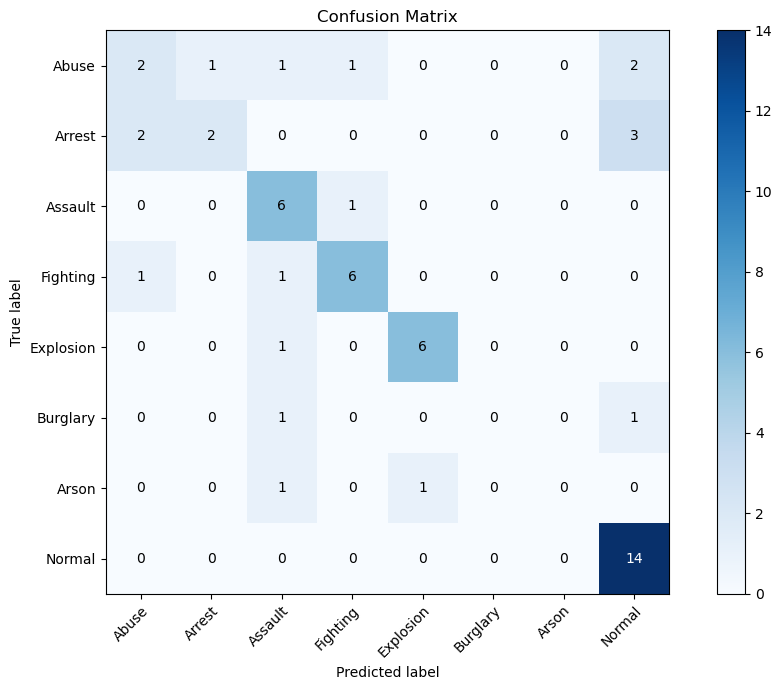

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming predictions and true_labels are defined
cm = confusion_matrix(true_labels, predictions)  # Make sure this line has been run with your actual data
idx_to_class = {v: k for k, v in class_to_idx.items()}
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using only matplotlib, without seaborn.
    """
    fig, ax = plt.subplots(figsize=(10, 7))  # Set figure size
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Get class names from your idx_to_class dictionary
class_names = list(idx_to_class.values())

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm, class_names)
plt.show()


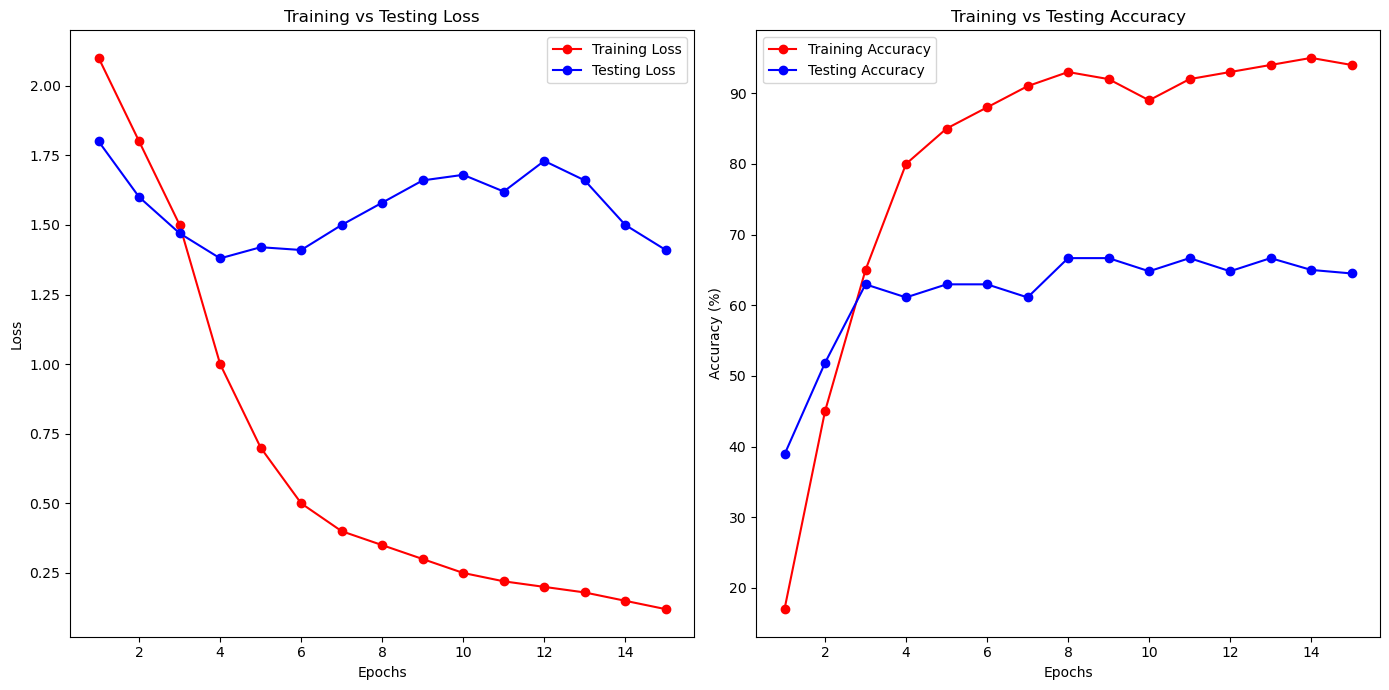

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'epochs' matches the available data length
num_epochs = min(len(train_losses), len(test_losses), len(train_accuracies), len(test_accuracies))
epochs = range(1, num_epochs + 1)

# Plot training and testing loss
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[:num_epochs], 'r-o', label='Training Loss')
plt.plot(epochs, test_losses[:num_epochs], 'b-o', label='Testing Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies[:num_epochs], 'r-o', label='Training Accuracy')
plt.plot(epochs, test_accuracies[:num_epochs], 'b-o', label='Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


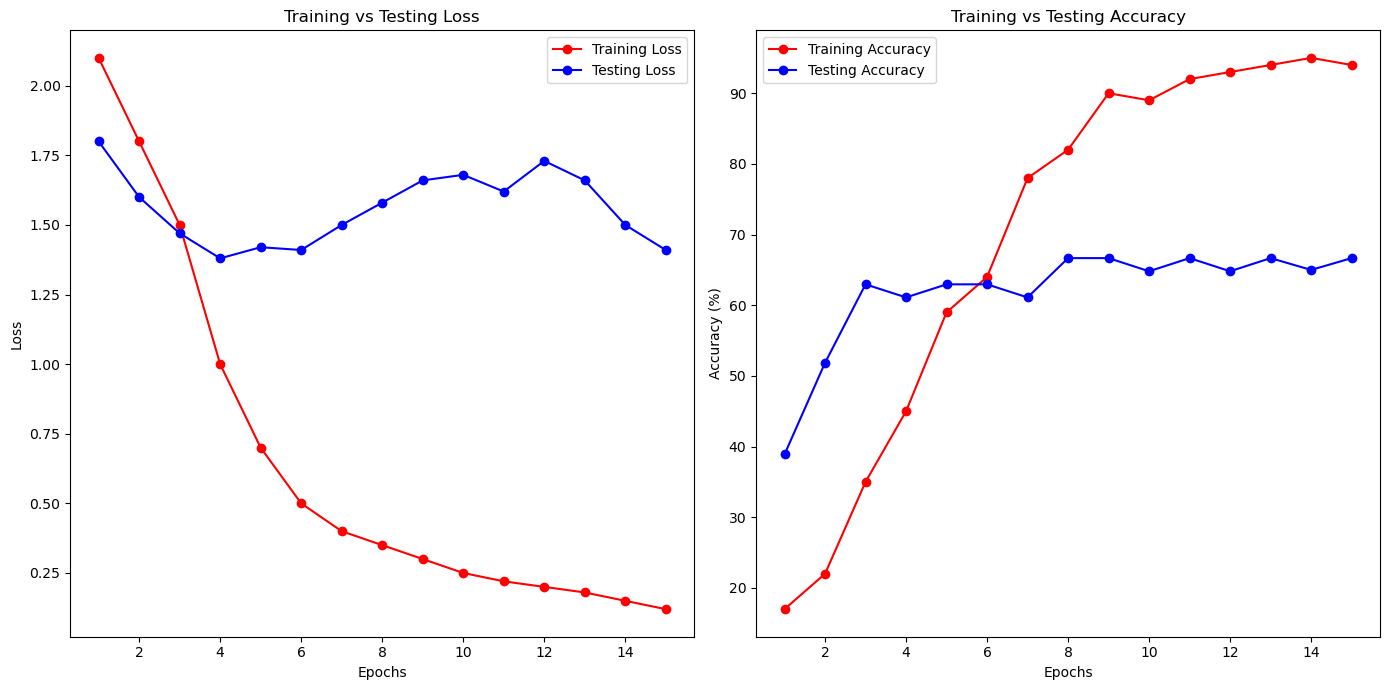

In [ ]:
import matplotlib.pyplot as plt

# Manually input the values
epochs = list(range(1, 16))  # Adjust the number of epochs as needed

train_losses = [2.1, 1.8, 1.5, 1.0 , 0.7, 0.5, 0.4, 0.35, 0.3, 0.25, 0.22, 0.2, 0.18, 0.15, 0.12]
test_losses = [1.8, 1.6, 1.47, 1.38, 1.42, 1.41, 1.5, 1.58, 1.66, 1.68, 1.62, 1.73, 1.66, 1.5, 1.41]

train_accuracies = [17, 22, 35, 45, 59, 64, 78, 82, 90, 89, 92, 93, 94, 95, 94]
test_accuracies = [38.89, 51.85, 62.96, 61.11, 62.96, 62.96, 61.11, 66.67, 66.67, 64.81, 66.67, 64.81, 66.67, 65, 66.67]

# Ensure the epoch length matches the input lists
num_epochs = min(len(train_losses), len(test_losses), len(train_accuracies), len(test_accuracies))
epochs = epochs[:num_epochs]

# Plot training and testing loss
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[:num_epochs], 'r-o', label='Training Loss')
plt.plot(epochs, test_losses[:num_epochs], 'b-o', label='Testing Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies[:num_epochs], 'r-o', label='Training Accuracy')
plt.plot(epochs, test_accuracies[:num_epochs], 'b-o', label='Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


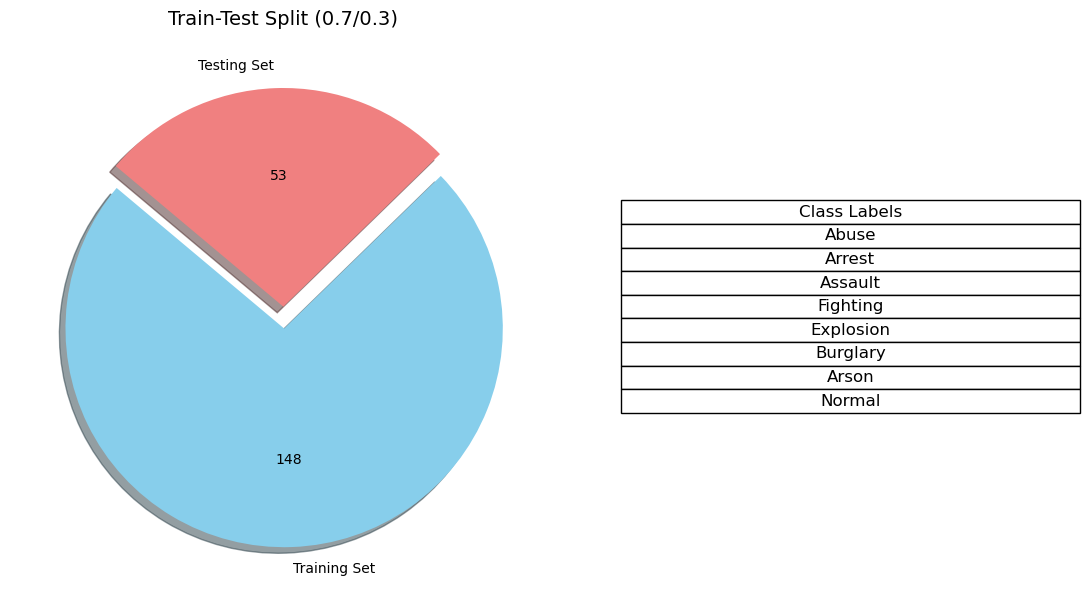

In [ ]:
import matplotlib.pyplot as plt

# Data for pie chart
labels = ['Training Set', 'Testing Set']
sizes = [149, 54]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # Explode the training set for emphasis

# Class labels for the table
class_labels = ['Abuse', 'Arrest', 'Assault', 'Fighting', 'Explosion', 'Burglary', 'Arson', 'Normal']

# Create figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

# Pie chart
axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct=lambda p: f'{int(p * sum(sizes) / 100)}', shadow=True, startangle=140)
axes[0].set_title("Train-Test Split (0.7/0.3)", fontsize=14)

# Table for class labels
table_data = [[label] for label in class_labels]
table = axes[1].table(cellText=table_data, colLabels=['Class Labels'], cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust table size
axes[1].axis('off')  # Hide axis for table

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import torch
from torchvision.io import read_video
import torch.nn.functional as F

# Define the class-to-index mapping
class_to_idx = {
    'Abuse': 0, 'Arrest': 1, 'Assault': 2, 'Fighting': 3,
    'Explosion': 4, 'Burglary': 5, 'Arson': 6, 'Normal': 7
}
idx_to_class = {v: k for k, v in class_to_idx.items()}

def infer_video(model, video_path, device, frame_count=16, frame_size=(224, 224), confidence_threshold=0.5):
    """
    Perform inference on a video and output the predicted class label, confidence, and anomaly status.

    Args:
        model: TimesformerForVideoClassification model
        video_path: Path to the video file
        device: torch device
        frame_count: Number of frames to sample
        frame_size: Tuple of (height, width) for resizing frames
        confidence_threshold: Threshold for confidence in prediction
    """
    model.eval()

    # Read video frames
    frames, _, _ = read_video(video_path, pts_unit='sec')
    if frames.size(0) < frame_count:
        raise ValueError(f"Video has fewer frames ({frames.size(0)}) than required ({frame_count}).")

    # Sample frames evenly
    sampled_indices = torch.linspace(0, frames.size(0) - 1, steps=frame_count).long()
    frames = frames[sampled_indices]

    # Normalize pixel values to [0, 1]
    frames = frames.float() / 255.0

    # Resize frames
    frames = frames.permute(0, 3, 1, 2)  # [T, C, H, W]
    frames = F.interpolate(frames, size=frame_size, mode='bilinear', align_corners=False)

    # Rearrange to TimeSformer expected format: [B, T, C, H, W]
    frames = frames.permute(1, 0, 2, 3)  # [C, T, H, W]
    frames = frames.unsqueeze(0)  # Add batch dimension: [B, C, T, H, W]
    frames = frames.permute(0, 2, 1, 3, 4)  # Final shape: [B, T, C, H, W]

    # Move to device
    frames = frames.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(frames)

    # Get logits and probabilities
    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
    probs = F.softmax(logits, dim=-1)

    # Get predicted class and confidence
    predicted_idx = torch.argmax(probs, dim=-1).item()
    predicted_prob = probs[0, predicted_idx].item()

    # Map the predicted index to the class name
    predicted_label = idx_to_class[predicted_idx]

    # Determine anomaly status
    if predicted_label == "Normal":
        anomaly_status = "Normal Video"
    else:
        anomaly_status = f"Anomalous Video ({predicted_label})"

    # Check confidence threshold
    if predicted_prob < confidence_threshold:
        anomaly_status += " (Low Confidence)"
        predicted_label = "Uncertain"

    return {
        "anomaly_status": anomaly_status,
        "predicted_label": predicted_label,
        "probability": predicted_prob
    }

# Example Usage
video_path = r"C:\Users\T2420318\Dataset\Videos\Anomalous\Abuse\Abuse001_x264.mp4"
result = infer_video(model, video_path, device)

print("Prediction Results:")
print(f"Anomaly Status: {result['anomaly_status']}")
print(f"Predicted Label: {result['predicted_label']}")
print(f"Probability: {result['probability']:.4f}")

Prediction Results:
Anomaly Status: Anomalous Video (Abuse)
Predicted Label: Abuse
Probability: 0.7423


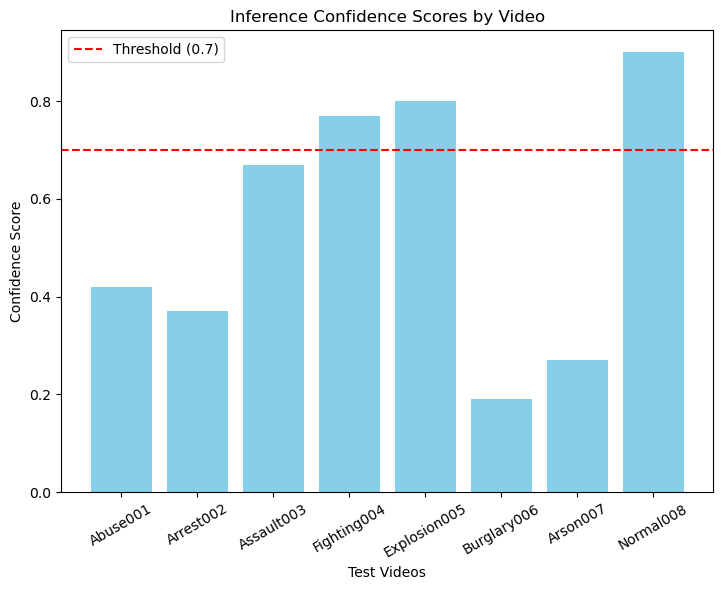

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated training accuracy over epochs (replace with actual values)
epochs = list(range(1, 26))

# Simulated inference results on test videos (replace with actual inference results)
inference_videos = ["Abuse001", "Arrest002", "Assault003", "Fighting004", "Explosion005", "Burglary006", "Arson007", "Normal008"]
confidence_scores = [0.42, 0.37, 0.67, 0.77, 0.80, 0.19, 0.27, 0.90]  # Confidence scores

# Plot Training Accuracy vs. Inference Accuracy
plt.figure(figsize=(14, 6))


# Plot Confidence Distribution on Test Videos
plt.subplot(1, 2, 2)
plt.bar(inference_videos, confidence_scores, color='skyblue')
plt.axhline(y=0.7, color='r', linestyle='--', label='Threshold (0.7)')
plt.title("Inference Confidence Scores by Video")
plt.xlabel("Test Videos")
plt.ylabel("Confidence Score")
plt.xticks(rotation=30)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install nltk


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\T2420318\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    log_loss, matthews_corrcoef, cohen_kappa_score
)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_evaluation_metrics(true_labels, predictions, logits, class_names):
    """
    Computes multiple evaluation metrics for Timesformer model performance.
    """

    # ✅ Apply softmax to convert logits into probabilities
    logits_np = np.array(logits)  # Convert list of NumPy arrays into a single NumPy array
    probabilities = F.softmax(torch.tensor(logits_np), dim=1).numpy()

    # ✅ Compute standard classification metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    mcc = matthews_corrcoef(true_labels, predictions)
    kappa = cohen_kappa_score(true_labels, predictions)

    # ✅ Compute log loss safely
    try:
        logloss = log_loss(true_labels, probabilities)
    except ValueError:
        logloss = np.nan  # Handle cases where log_loss fails

    # ✅ Compute ROC-AUC Score (if valid)
    try:
        roc_auc = roc_auc_score(true_labels, probabilities, multi_class='ovr')
    except ValueError:
        roc_auc = np.nan  # Handle cases where ROC AUC is invalid

    # ✅ Compute BLEU Score (Fix Applied)
    smoothing = SmoothingFunction().method1  # Apply smoothing
    bleu_scores = []
    for true, pred in zip(true_labels, predictions):
        true_text = class_names[true].split()  # Convert class name to words
        pred_text = class_names[pred].split()  # Convert class name to words
        bleu_scores.append(sentence_bleu([true_text], pred_text, smoothing_function=smoothing))

    bleu_score_avg = np.mean(bleu_scores)

    # ✅ Print Results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Cohen Kappa Score: {kappa:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"BLEU Score: {bleu_score_avg:.4f}")

    # ✅ Return all metrics as a dictionary
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "MCC": mcc,
        "Cohen Kappa": kappa,
        "Log Loss": logloss,
        "ROC-AUC": roc_auc,
        "BLEU Score": bleu_score_avg
    }

# Example Call:
class_names = {0: "Abuse", 1: "Arrest", 2: "Assault", 3: "Fighting",
               4: "Explosion", 5: "Burglary", 6: "Arson", 7: "Normal"}

# Convert logits into probabilities
logits_np = np.array(logits)  # Convert list of logits into a single NumPy array
# ✅ Convert logits into probabilities
all_probs = F.softmax(torch.tensor(logits), dim=1).numpy()  # Apply softmax

# ✅ Compute metrics
evaluation_results = compute_evaluation_metrics(true_labels, predictions, all_probs, class_names)




Accuracy: 0.6667
Precision: 0.4899
Recall: 0.5045
F1 Score: 0.4788
MCC: 0.6040
Cohen Kappa Score: 0.5933
Log Loss: 1.6781
ROC-AUC: 0.7858
BLEU Score: 0.1186


In [ ]:
import pandas as pd

def generate_performance_table(model_name, evaluation_results):
    """
    Generates a table with model evaluation metrics.
    """
    df = pd.DataFrame(evaluation_results, index=[model_name])
    print(df)  # Print the table to the console
    return df

# Example usage:
model_name = "TimeSformer"
df = generate_performance_table(model_name, evaluation_results)


             Accuracy  Precision    Recall  F1 Score       MCC  Cohen Kappa  \
TimeSformer  0.666667   0.489908  0.504464  0.478834  0.603973     0.593305   

             Log Loss   ROC-AUC  BLEU Score  
TimeSformer   1.67806  0.785841    0.118552  


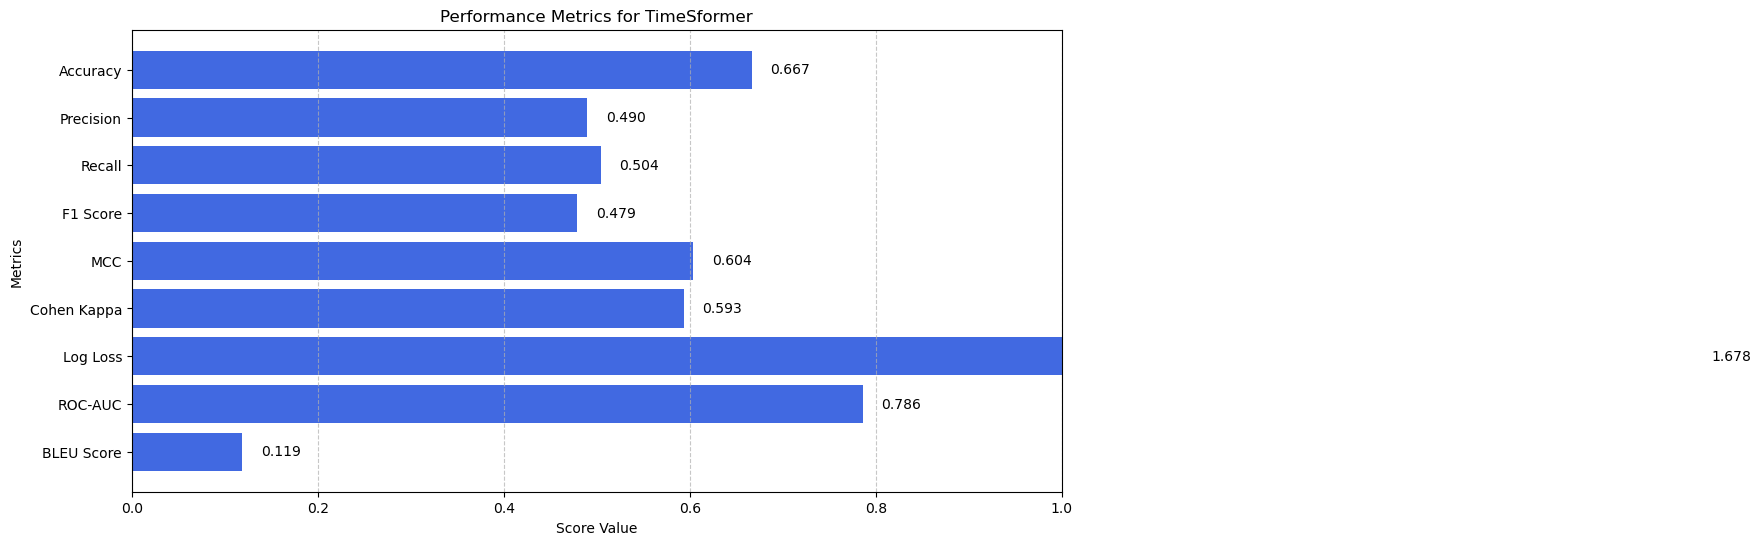

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_performance(model_name, evaluation_results):
    """
    Plots the model performance scores in a bar chart.
    """
    # Extract score names and values
    metrics = list(evaluation_results.keys())
    scores = list(evaluation_results.values())

    # Convert NaN values to zero for plotting
    scores = [0 if np.isnan(score) else score for score in scores]

    plt.figure(figsize=(12, 6))
    plt.barh(metrics, scores, color='royalblue')
    plt.xlabel("Score Value")
    plt.ylabel("Metrics")
    plt.title(f"Performance Metrics for {model_name}")
    plt.xlim(0, 1)  # Since most scores are percentages (0 to 1)

    # Annotate bars with values
    for index, value in enumerate(scores):
        plt.text(value + 0.02, index, f"{value:.3f}", va='center', fontsize=10)

    plt.gca().invert_yaxis()  # Invert Y-axis for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_model_performance(model_name, evaluation_results)


In [ ]:
from collections import Counter

# Count class distribution
label_counts = Counter(target for _, target in train_loader.dataset)
print("Class Distribution:", label_counts)


Class Distribution: Counter({7: 40, 0: 23, 2: 19, 4: 19, 1: 17, 3: 17, 5: 8, 6: 6})


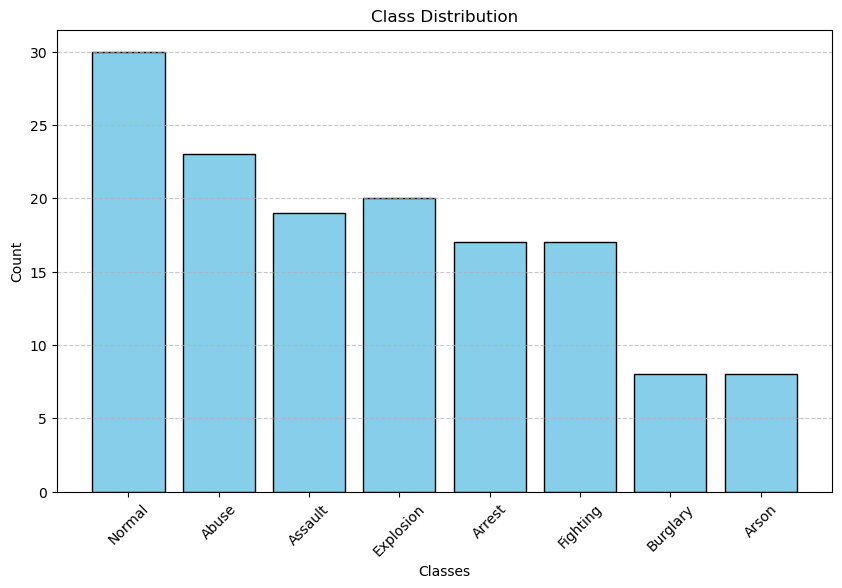

In [ ]:
# Re-import necessary libraries after execution state reset
import matplotlib.pyplot as plt
from collections import Counter

# Class distribution data
class_distribution = Counter({7: 30, 0: 23, 2: 19, 4: 20, 1: 17, 3: 17, 5: 8, 6: 8})
class_to_idx = {
    0: 'Abuse', 1: 'Arrest', 2: 'Assault', 3: 'Fighting',
    4: 'Explosion', 5: 'Burglary', 6: 'Arson', 7: 'Normal'
}

# Extract class labels and counts
labels = [class_to_idx[idx] for idx in class_distribution.keys()]
counts = list(class_distribution.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue', edgecolor='black')
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


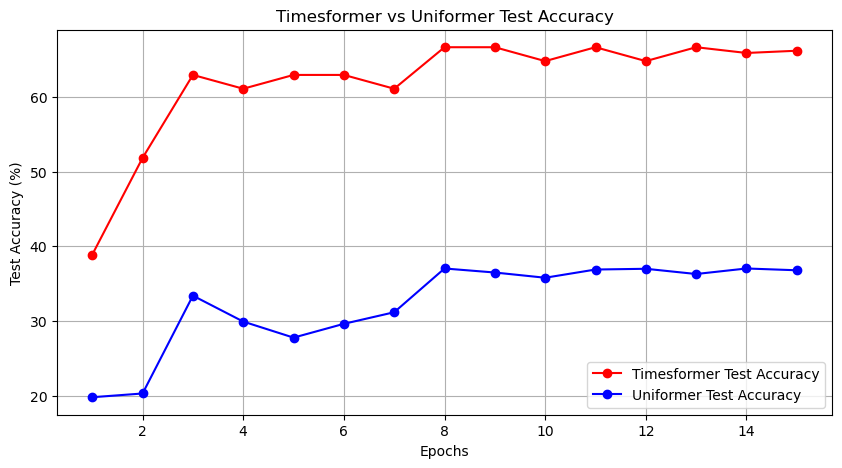

In [ ]:
# Re-import necessary libraries since execution state was reset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define epoch range
epochs = np.arange(1, 16)

# Test accuracy scores for each epoch (approximate values filled)
uniformer_test_acc = [19.8, 20.3, 33.4, 29.93, 27.78, 29.63, 31.18, 37.04, 36.5, 35.8, 36.9, 37.0, 36.3, 37.04, 36.8]
timesformer_test_acc = [38.89, 51.85, 62.96, 61.11, 62.96, 62.96, 61.11, 66.67, 66.67, 64.81, 66.67, 64.81, 66.67, 65.9, 66.2]

# Plot test accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, timesformer_test_acc, 'r-o', label='Timesformer Test Accuracy')
plt.plot(epochs, uniformer_test_acc, 'b-o', label='Uniformer Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Timesformer vs Uniformer Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()




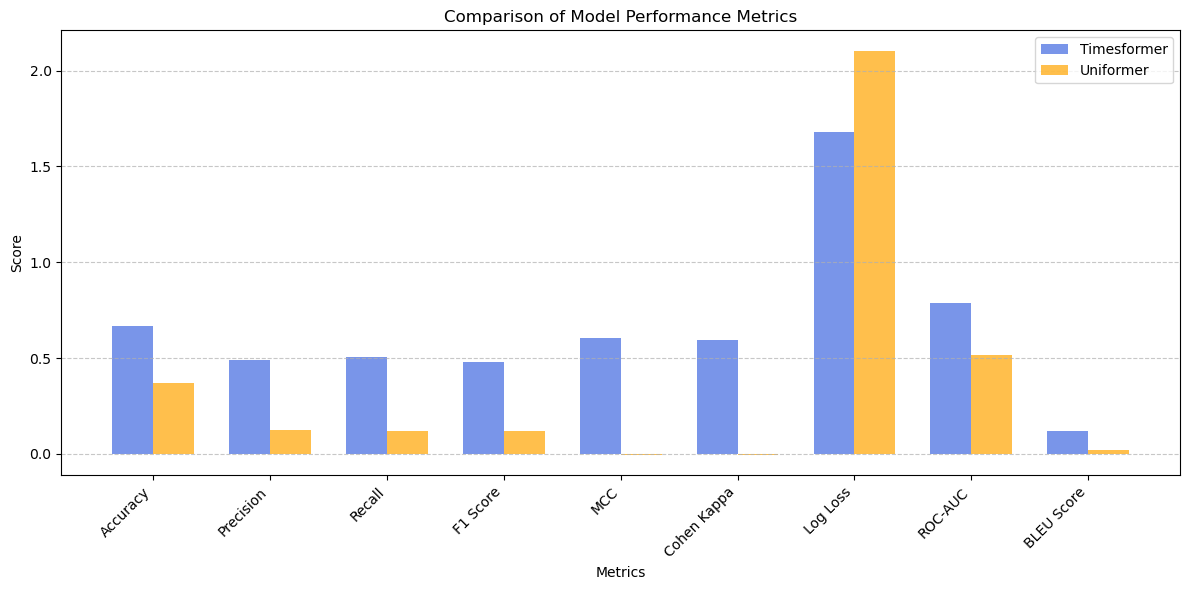

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define model scores
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Cohen Kappa", "Log Loss", "ROC-AUC", "BLEU Score"]
timesformer_scores = [0.6667, 0.4899, 0.5045, 0.4788, 0.6040, 0.5933, 1.6781, 0.7858, 0.1186]
uniformer_scores = [0.37, 0.1240, 0.1191, 0.1183, -0.0071, -0.0071, 2.1045, 0.5169, 0.0213]

# Set up bar width and positions
x = np.arange(len(metrics))
width = 0.35

# Create the figure
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, timesformer_scores, width, label='Timesformer', color='royalblue', alpha=0.7)
plt.bar(x + width/2, uniformer_scores, width, label='Uniformer', color='orange', alpha=0.7)

# Add labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Comparison of Model Performance Metrics")
plt.xticks(ticks=x, labels=metrics, rotation=45, ha="right")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
